# ASSIGNMENT 4: Animal Classification of Images using Neural Network and CNN

In this assignment we have a data collection of 28000 images belonging to ten different classes. In the first part, using these images of animals as training data, we will attempt to build a neural network. As a consequence of our research, we will first attempt to classify using a single layer neural network, then compare the results by attempting to classify using a multilayer neural network. We will next try to decide which structure is the most appropriate for animal categorization. Similary, in the second part, we will classify animal images by using CNN with VGG-19.

## PART 1: Neural Network

A neural network is made up of many processors that function in parallel and are grouped in tiers. The raw input information is received by the first tier, which functions similarly to the optic neurons in human visual processing. In the same manner that neurons further away from the optic nerve receive signals from those closer to it, each succeeding tier receives the output from the layer before it rather than the raw input. The system's output is produced by the last tier. Each processing node has its own sphere of knowledge, which includes what it has seen as well as any rules it was programmed with or created for itself.

Neural networks are known for being adaptable, which means they change as they learn from their initial training and deliver more information about the world in subsequent runs. Weighting the input streams, which is how each node weights the relevance of information from each of its predecessors, is the simplest fundamental learning model. Inputs that help you get the right responses are given more weight.

Unlike other algorithms, neural networks cannot be explicitly programmed for the task due to their deep learning. Rather, they are required to learn the material, much as a child's developing brain is required to learn. There are three types of learning strategies: supervised, unsupervised and reinforced learning. In this assignment we will use supervised learning method. This technique in supervised learning is the simplest, as it involves the computer going through a labeled dataset and modifying the algorithm until it can analyze the dataset and produce the intended result.

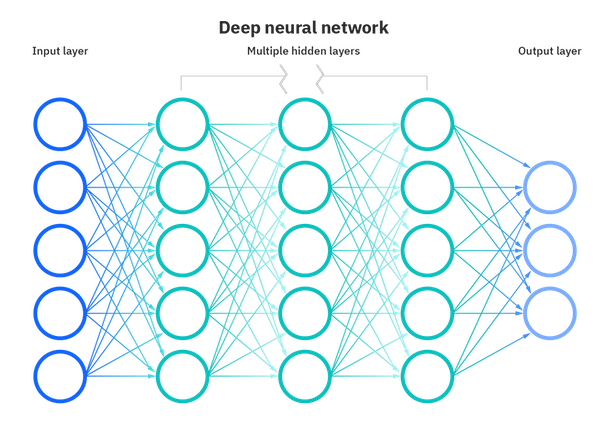

As can be seen from the figure above, a neural network consists of an input layer, zero or more hidden layers and an output layer. In our case, we will first resize the given images, convert them to pixels and flatten them. Thus, our input layer will consist of the number of pixels in our images. Moreover, since we have 10 different classes which are cane, cavallo, elefante, farfalla, gallina, gatto, mucca, pecaro, ragno and scoiattollo, the number of neurons in the output layer will be 10. 

In this assignment, we will test our algorithm on single layer network firstly (only input and output layer), then with one hidden layer and lastly with two hidden layers (multi layer neural network).

Each network neuron (excluding those in the input layer) is made up of the total of all its inputs, which are the previous layer's outputs multiplied by some weights. This total is then multiplied by a bias term. The result is then subjected to a nonlinear function known as the activation function. These numerical values (weights, bias) are exactly what we'll strive to change by training the network with a pre-labeled dataset. After we initialize the parameters, we’ll proceed iteratively by following an optimization algorithm that will try to minimize the difference between the actual output and the one estimated by the network

If we think in general, what we do in this assignment is that we will first feed input data into the neural network, then the data flows from one layer to another until we obtain an output. Once we have the output, we can calculate the error, finally, we will change a parameter's weight or bias by removing the error's derivative with respect to the parameter. We will iterate through the process and train the neural network then calculate the accuracy and analyze results obtained.

The neural network algorithm determines the parameters (weights and biases) by applying forward propagation and backpropagation. Forward and backward propagation are interdependent when training neural networks. Forward propagation, in particular, traverses the computational network in the direction of dependence, computing all variables along the way. These are then used for backpropagation, which reverses the graph's compute order.

### Code Implementations

In [3]:
import os
import pickle

import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt

In [15]:
class Dataset:
    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
        "dog": "cane",
        "horse": "cavallo",
        "elephant" : "elefante",
        "butterfly": "farfalla",
        "chicken": "gallina",
        "cat": "gatto",
        "cow": "mucca",
        "sheep": "pecora",
        "spider": "ragno",
        "squirrel": "scoiattolo"
    }

    def __init__(self, data_parent='data/'):
        super().__init__()

        self.data_path = os.path.join(data_parent, 'raw-img')

        self.org_names = list(self.translate.keys())[:10]
        self.eng_names = list(self.translate.keys())[10:]
        
        print("*")
        print()
        self.data_paths = []
        for i in range(len(self.org_names)):
            img_paths = glob(
                os.path.join(self.data_path, self.org_names[i], '*')
            )
            
            self.data_paths.extend(list(zip(img_paths, [i] * len(img_paths))))
        
        self.mean = 0.459
        self.var = 0.269

    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, index):
        img_path, label = self.data_paths[index]
        img = Image.open(img_path).convert('L').resize((64, 64))
        img_arr = np.asarray(img)
        img_arr = img_arr / 255
        img_arr = (img_arr - self.mean) / self.var
        img_arr = img_arr.flatten()

        return img_arr, label

    def getlabel(self, index):
        return self.data_paths[index][1]


In [16]:
def fully_connected(X, params):
    W, b = params

    out = (X @ W) + b
    dx = W
    dw = X
    db = np.ones_like(out)  # Not used

    return {'out': out, 'dx': dx, 'dw': dw, 'db': db}

In [17]:
def LRelu(X, a):
    out = np.where(X<0, X*a, X)

    # Derivative for Gradient Descent
    dx = np.where(X<0, a, 1)

    return {'out': out, 'dx': dx}

In [18]:
def softmax_nll(X, Y):
    # Extract max for numerical stability.
    x_max = np.max(X, axis=1, keepdims=True)

    # Unstable
    # e_x = np.exp(X - x_max)
    # probs = e_x / np.sum(e_x, axis=1, keepdims=True)

    log_e_x = np.log(np.sum(np.exp(X - x_max), axis=1, keepdims=True))
    log_probs = X - x_max - log_e_x
    
    # Compute loss
    N = X.shape[0]
    out = -np.sum(log_probs[np.arange(N), Y]) / N
    
    # Derivative for Gradient Descent
    dx = np.exp(log_probs)
    dx[np.arange(N), Y] = dx[np.arange(N), Y] - 1
    dx = dx/N

    return {'out': out, 'dx': dx}

In [19]:
def softmax_nll_eval(X, Y):
    # Extract mean for numerical stability.
    x_max = np.max(X, axis=1, keepdims=True)

    # Unstable
    # e_x = np.exp(X - np.max(X, axis=1, keepdims=True))
    # probs = e_x / np.sum(e_x,axis=1, keepdims=True)

    log_e_x = np.log(np.sum(np.exp(X - x_max), axis=1, keepdims=True))
    log_probs = X - x_max - log_e_x

    return {'out': np.argmax(log_probs, axis=1)}

In [20]:
def test(network, dataset, test_set, batch_size, epoch):
    iter_count = len(test_set) // batch_size

    data_index = 0
    epoch_tqdm = tqdm(
        range(iter_count), total=iter_count, leave=True, desc=f"Test {epoch}"
    )

    targets = []
    predictions = []
    for iter in epoch_tqdm:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = dataset[train_set[data_index]]
            X.append(x)
            Y.append(y)
            data_index += 1
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        output_of_previous_layer = X

        for f in network:
            if f == softmax_nll_eval:
                y = f(output_of_previous_layer, None)
            else:
                y = f[0](output_of_previous_layer, f[1])
            output_of_previous_layer = y['out']

        predictions.extend(y['out'])
        targets.extend(Y)
    
    return np.asarray(targets), np.asarray(predictions)

In [21]:
def train_one_epoch(network, dataset, train_set, lr, batch_size, epoch):
    iter_count = len(train_set) // batch_size
    
    loss_vals = []

    data_index = 0
    epoch_tqdm = tqdm(
        range(iter_count), total=iter_count, leave=True, desc=f"Train {epoch}:"
    )
    for iter in epoch_tqdm:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = dataset[train_set[data_index]]
            X.append(x)
            Y.append(y)
            data_index += 1
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        output_of_previous_layer = X

        out_list = []
        for f in network:
            if f == softmax_nll:
                y = f(output_of_previous_layer, Y)
            else:
                y = f[0](output_of_previous_layer, f[1])
            out_list.append(y)
            output_of_previous_layer = y['out']

        loss_vals.append(y['out'])

        dout = out_list[-1]['dx']
        for i in range(len(network)-2, -1, -1):
            if network[i][0] == fully_connected:
                network[i][1][0] = (
                    network[i][1][0] - lr * out_list[i]['dw'].T @ dout
                )
                network[i][1][1] = (
                    network[i][1][1] - lr * np.sum(dout, axis=0, keepdims=True)
                )

                dout = dout @ out_list[i]['dx'].T
            
            elif network[i][0] == LRelu:
                dout = dout * out_list[i]['dx']

    return network, loss_vals


In [28]:
if __name__ == "__main__":
    np.random.seed(123)

    batch_size = 16
    dataset = Dataset()

    test_set_size = len(dataset)//10
    train_set_size = len(dataset)-test_set_size

    indices = np.arange(len(dataset))
    indices = np.random.permutation(indices)

    train_set = indices[:train_set_size]
    test_set = indices[train_set_size:]

    # Discard last batch if not compatible with batch size
    test_set_size = (test_set_size // batch_size) * batch_size
    train_set_size = (train_set_size // batch_size) * batch_size
    train_set = indices[:train_set_size]
    test_set = indices[:test_set_size]

    model_name = 'mlnn.pth'
    is_train = False

    if is_train:
        # Number of units in network
        neurons = [4096, 10]
        batch_size = 64
        lr = 0.01

        # Create model
        xav_lim = 1 / np.sqrt(neurons[0])
        network = []
        for i in range(1, len(neurons)):
            network.append([
                fully_connected,
                [  # Xavier initialization: [-1/sqrt_inp_neur, 1/sqrt_inp_neur]
                    np.random.rand(
                        neurons[i-1], neurons[i]
                    ) * 2 * xav_lim - xav_lim,  # Weights
                    np.zeros((1, neurons[i]))  # Biases
                ]
            ])

            if i != len(neurons) - 1:
                network.append([LRelu, 0.1])
            else:
                network.append(softmax_nll)

        # Training loop
        best_acc = -100
        full_loss_vals = []
        for epoch in range(1, 10+1):
            # Train
            network[-1] = softmax_nll
            network, loss_vals = train_one_epoch(
                network, dataset, train_set, .1, batch_size, epoch
            )

            # LR scheduler
            lr *= 0.9

            full_loss_vals.extend(loss_vals)

            # Eval
            network[-1] = softmax_nll_eval
            targets, predictions = test(
                network, dataset, test_set, batch_size, epoch
            )

            test_acc = np.mean(targets == predictions) * 100

            print(f"Accuracy: {test_acc:.2f}%")

            if test_acc >= best_acc:
                pickle.dump(network, open(model_name, 'wb'))

                best_acc = test_acc

        plt.plot(loss_vals)
        plt.savefig("part1_train_loss_vals.png")

    else:
        model_path = "models/mlnn_2.pth"
        network = pickle.load(open(model_path, 'rb'))

        # Eval
        network[-1] = softmax_nll_eval
        targets, predictions = test(
            network, dataset, test_set, batch_size, "Run"
        )

        conf_mat = np.zeros((10, 10))
        for t, p in zip(targets, predictions):
            conf_mat[t, p] += 1

        test_acc = np.mean(targets == predictions) * 100
        print(f"Accuracy: {test_acc:.2f}%")

        print("Confusion matrix:")
        print(conf_mat)


Test Run: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:04<00:00, 33.10it/s]

Accuracy: 57.02%
Confusion matrix:
[[215.  17.  16.   9.   8.  59.  22.  24.  89.  13.]
 [ 23. 174.   2.   1.   1.   3.  31.   8.  19.   5.]
 [ 21.   7.  53.   7.   2.   3.   4.   7.  18.   6.]
 [  9.   2.   5.  80.   8.  29.   2.   5.  58.  10.]
 [ 25.   9.   2.   7. 172.  13.  12.  14.  40.  16.]
 [ 29.   5.   2.   4.   1.  59.   3.   8.  39.   7.]
 [ 10.  11.   3.   4.   1.   7. 117.  19.   8.   2.]
 [ 10.   2.   1.   1.   4.   7.  22. 119.  26.   7.]
 [  6.  10.   9.   7.   5.  28.   7.  15. 388.  10.]
 [ 10.   7.   5.   6.   3.  18.   1.   5.  35. 110.]]


In [14]:
import numpy as np

conf_mat = [[215.,  17.,  16. ,  9.,  8.,  59.,  22.,  24.,  89., 13.],    
 [ 23., 174.,   2. ,  1.,  1.,   3.,  31.,   8.,  19.,  5.],    
 [ 21.,   7.,  53. ,  7.,  2.,   3.,   4.,   7.,  18.,  6.],    
 [  9.,   2.,   5. , 80.,  8.,  29.,   2.,   5.,  58., 10.],    
 [ 25.,   9.,   2. ,  7.,172.,  13.,  12.,  14.,  40., 16.],    
 [ 29.,   5.,   2. ,  4.,  1.,  59.,   3.,   8.,  39.,  7.],    
 [ 10.,  11.,   3. ,  4.,  1.,   7., 117.,  19.,   8.,  2.],    
 [ 10.,   2.,   1. ,  1.,  4.,   7.,  22., 119.,  26.,  7.],    
 [  6.,  10.,   9. ,  7.,  5.,  28.,   7.,  15., 388., 10.],    
 [ 10.,   7.,   5. ,  6.,  3.,  18.,   1.,   5.,  35.,110.]]    

conf_mat = np.asarray(conf_mat)

num_class = len(conf_mat)

TP = conf_mat.diagonal()  # True positive
AP = np.sum(conf_mat, axis=0)  # TP + FP
AT = np.sum(conf_mat, axis=1)  # TP + FN

precision = TP / AP
recall = TP / AT
F1 = (2 * precision * recall) / (precision + recall)
accuracy = conf_mat.diagonal()/conf_mat.sum(1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", F1)

Accuracy: [0.45550847 0.65168539 0.4140625  0.38461538 0.55483871 0.37579618
 0.64285714 0.59798995 0.8        0.55      ]
Precision: [0.60055866 0.71311475 0.54081633 0.63492063 0.83902439 0.26106195
 0.52941176 0.53125    0.53888889 0.59139785]
Recall: [0.45550847 0.65168539 0.4140625  0.38461538 0.55483871 0.37579618
 0.64285714 0.59798995 0.8        0.55      ]
F1: [0.51807229 0.68101761 0.46902655 0.47904192 0.66796117 0.30809399
 0.58064516 0.56264775 0.6439834  0.56994819]


## Analysis

## Batch Size

In [49]:
from matplotlib import pyplot as plt
def plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, layer, lr):   
    epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.figure(figsize=(20, 10))
    #plt.suptitle(batchtype+ lr + layer)
    plt.subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.plot(epoch, loss_16, color="blue", label="Batch Size: 16", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_32, color="red", label="Batch Size: 32", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_64, color="green", label="Batch Size: 64", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_128, color="orange", label="Batch Size: 128", linewidth=1, linestyle="-")



    #plt.plot(epoch, valid_loss, color="red", label="validation", linewidth=1, linestyle="-")
    plt.legend(loc='lower left')
    plt.subplot(1, 2, 2)
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, acc_16, color="blue", label="Batch Size: 16", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_32, color="red", label="Batch Size: 32", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_64, color="green", label="Batch Size: 64", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_128, color="orange", label="Batch Size: 128", linewidth=1, linestyle="-")

    plt.legend(loc='lower left')
    plt.savefig("graphs_batch"+"/"+layer+lr+".png")
    #plt.close()

We can not pass the whole dataset into our model to train it, so we split the dataset into batches, instead of training the model on whole in a single phase. The main reason we use batch is that the backpropagation process slows down the learning process. When we use batch you get speed, but noise may be a bad thing. 

When we observe the average loss according to the change in batch size for the below single layer, one hidden layer and two hidden layer neural networks, the first thing that stands out is that in a single layer neural network, the average loss decreases as the number of batch increases. Average loss is higher in one hidden layer and two hidden layers neural network.


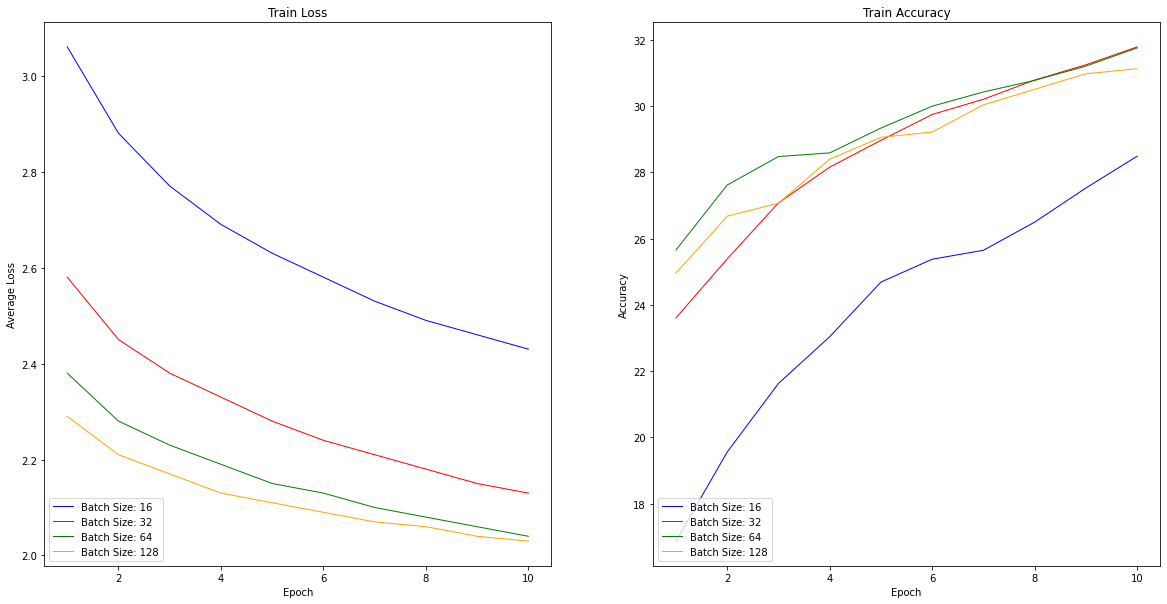

In [50]:
#lr = 0.01, Neurons: [4096, 10]
loss_16 = [3.06, 2.88, 2.77, 2.69, 2.63, 2.58, 2.53, 2.49, 2.46, 2.43]
acc_16 = [16.87, 19.56, 21.63, 23.04, 24.69, 25.38, 25.65, 26.50, 27.53, 28.49]

loss_32 = [2.58, 2.45, 2.38, 2.33, 2.28, 2.24, 2.21, 2.18, 2.15, 2.13]
acc_32 = [23.61, 25.39, 27.08, 28.16, 28.97, 29.75, 30.21, 30.79, 31.25, 31.79]

loss_64 = [2.38, 2.28, 2.23, 2.19, 2.15, 2.13, 2.10, 2.08, 2.06, 2.04]
acc_64 = [25.66, 27.62, 28.48, 28.59, 29.34, 30.00, 30.43, 30.78, 31.21, 31.76]

loss_128 = [2.29, 2.21, 2.17, 2.13, 2.11, 2.09, 2.07, 2.06, 2.04, 2.03]
acc_128 = [24.96, 26.68, 27.07, 28.40, 29.06, 29.22, 30.04, 30.51, 30.98, 31.13]

plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, " Single Layer ", " Learning Rate: 0.01 ")

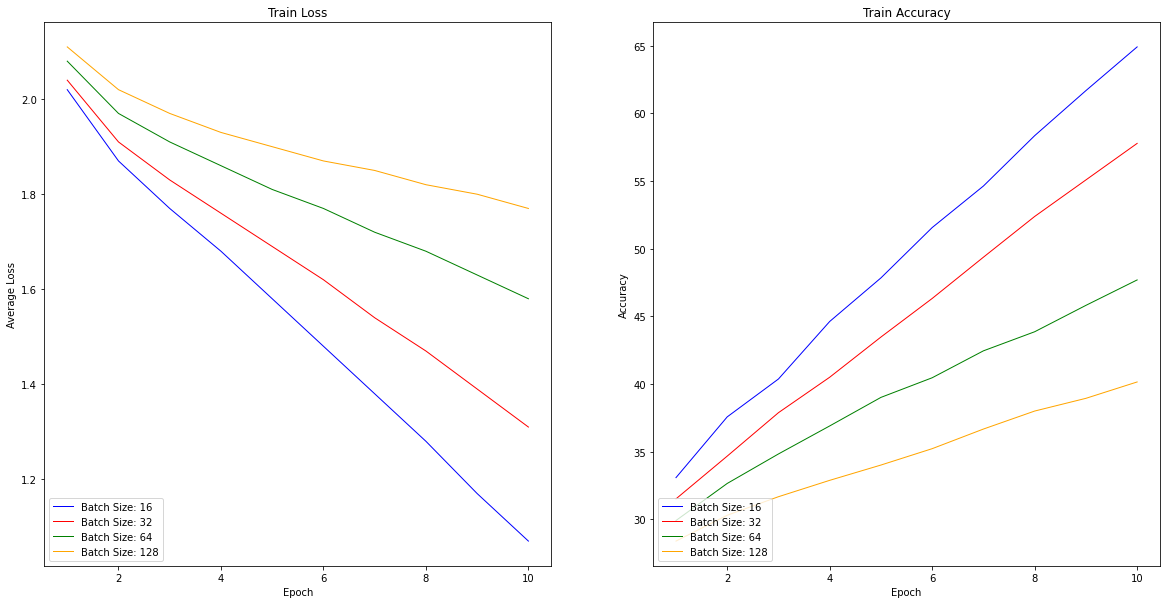

In [51]:
#lr = 0.01, Neurons: [4096, 1024, 10]
loss_16 = [2.02, 1.87, 1.77, 1.68, 1.58, 1.48, 1.38, 1.28, 1.17, 1.07]
acc_16 = [33.09, 37.58, 40.38, 44.63, 47.85, 51.57, 54.64, 58.36, 61.69, 64.92]

loss_32 = [2.04, 1.91, 1.83, 1.76, 1.69, 1.62, 1.54, 1.47, 1.39, 1.31]
acc_32 = [31.52, 34.68, 37.89, 40.51, 43.48, 46.33, 49.38, 52.39, 55.09, 57.79]

loss_64 = [2.08, 1.97, 1.91, 1.86, 1.81, 1.77, 1.72, 1.68, 1.63, 1.58]
acc_64 = [29.92, 32.66, 34.84, 36.91, 39.02, 40.47, 42.46, 43.87, 45.82, 47.70]

loss_128 = [2.11, 2.02, 1.97, 1.93, 1.90, 1.87, 1.85, 1.82, 1.80, 1.77]
acc_128 = [28.40, 30.31, 31.68, 32.89, 34.02, 35.23, 36.68, 38.01, 38.95, 40.16]
plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, " One Hidden Layer ", " Learning Rate: 0.01 ")

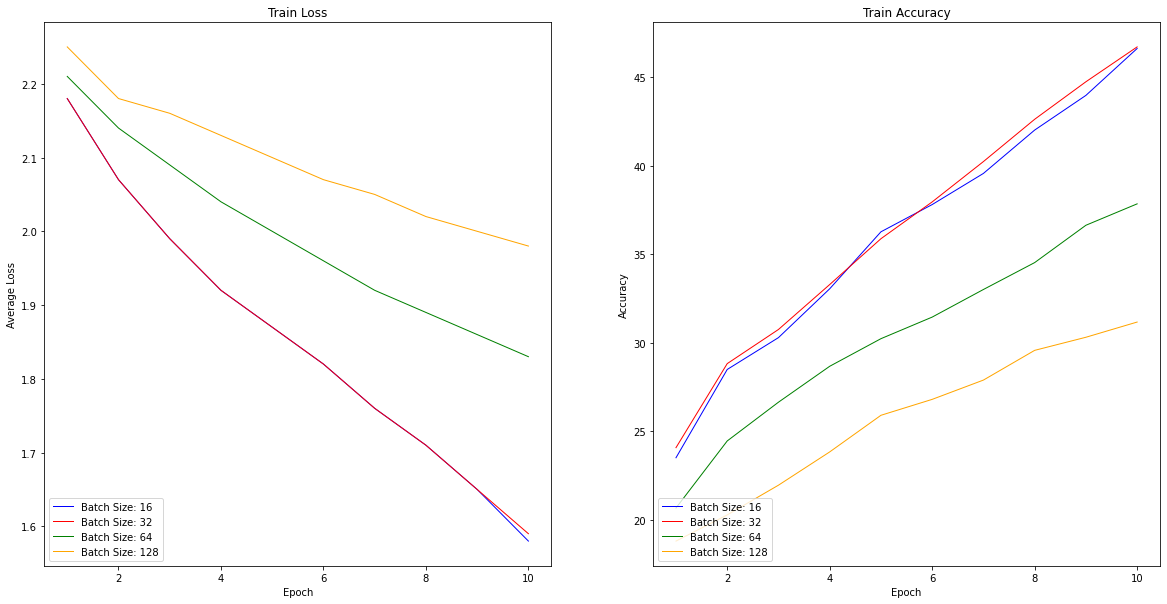

In [52]:
#lr = 0.01, Neurons: [4096, 1024, 256, 10]
loss_16 = [2.18, 2.07, 1.99, 1.92, 1.87, 1.82, 1.76, 1.71, 1.65, 1.58]
acc_16 = [23.50, 28.49, 30.29, 33.05, 36.27, 37.81, 39.57, 42.02, 43.98, 46.63]

loss_32 = [2.18, 2.07, 1.99, 1.92, 1.87, 1.82, 1.76, 1.71, 1.65, 1.59]
acc_32 = [24.07, 28.82, 30.75, 33.29, 35.88, 37.96, 40.24, 42.63, 44.75, 46.72]

loss_64 = [2.21, 2.14, 2.09, 2.04, 2.00, 1.96, 1.92, 1.89, 1.86, 1.83]
acc_64 = [20.66, 24.45, 26.64, 28.67, 30.23, 31.45, 33.01, 34.53, 36.64, 37.85]

loss_128 = [2.25, 2.18, 2.16, 2.13, 2.10, 2.07, 2.05, 2.02, 2.00, 1.98]
acc_128 = [18.79, 20.27, 21.95, 23.83, 25.90, 26.80, 27.89, 29.57, 30.31, 31.17]
plot_graph_batch(loss_16, loss_32, loss_64, loss_128, acc_16, acc_32, acc_64, acc_128, " Two Hidden Layers ", " Learning Rate: 0.01 ")

## Learning Rate

In [53]:
from matplotlib import pyplot as plt
def plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02, layer, lr):   
    epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.figure(figsize=(20, 10))
    #plt.suptitle(batchtype+ lr + layer)
    plt.subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.plot(epoch, loss_005, color="blue", label="Learning Rate: 0.005", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_01, color="red", label="Learning Rate: 0.01", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_02, color="green", label="Learning Rate: 0.02", linewidth=1, linestyle="-")


    #plt.plot(epoch, valid_loss, color="red", label="validation", linewidth=1, linestyle="-")
    plt.legend(loc='lower left')
    plt.subplot(1, 2, 2)
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, acc_005, color="blue", label="Learning Rate: 0.005", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_01, color="red", label="Learning Rate: 0.01", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_02, color="green", label="Learning Rate: 0.02", linewidth=1, linestyle="-")

    plt.legend(loc='lower left')
    plt.savefig("graphs_batch"+"/"+layer+lr+".png")
    #plt.close()

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

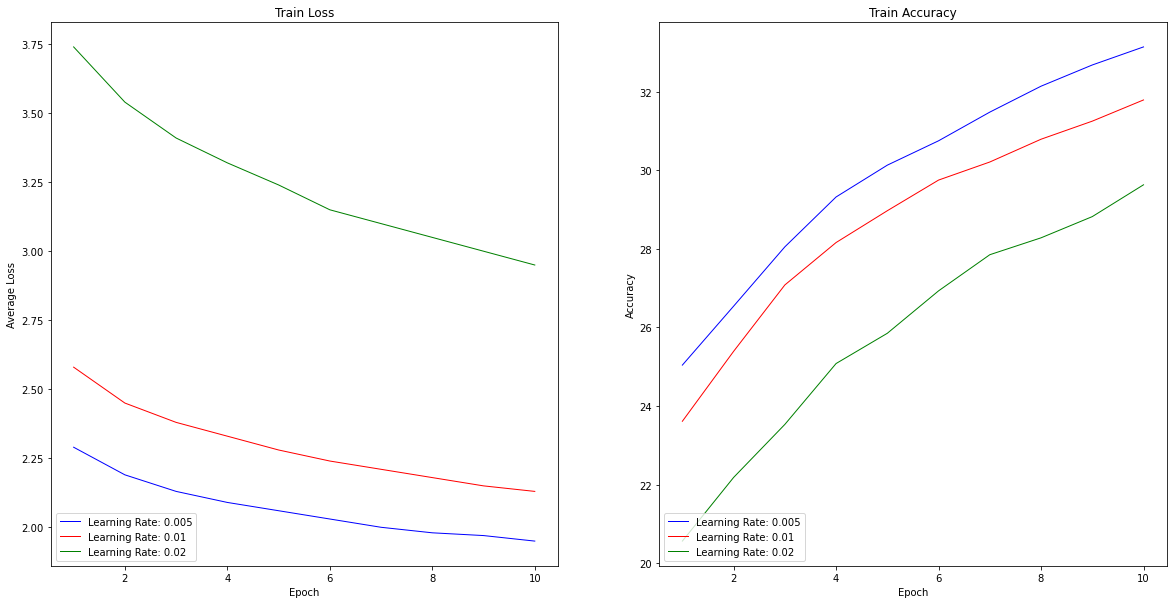

In [54]:
#Neurons: [4096, 10] Batch Size: 32
loss_005 = [2.29, 2.19, 2.13, 2.09, 2.06, 2.03, 2.00, 1.98, 1.97, 1.95]
acc_005 = [25.04, 26.54, 28.05, 29.32, 30.13, 30.75, 31.48, 32.14, 32.68, 33.14]

loss_01 = [2.58, 2.45, 2.38, 2.33, 2.28, 2.24, 2.21, 2.18, 2.15, 2.13]
acc_01 = [23.61, 25.39, 27.08, 28.16, 28.97, 29.75, 30.21, 30.79, 31.25, 31.79]

loss_02 = [3.74, 3.54, 3.41, 3.32, 3.24, 3.15, 3.10, 3.05, 3.00, 2.95]
acc_02 = [20.56, 22.18, 23.53, 25.08, 25.85, 26.93, 27.85, 28.28, 28.82, 29.63]

plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Single Layer ", " Batch Size: 32 ")

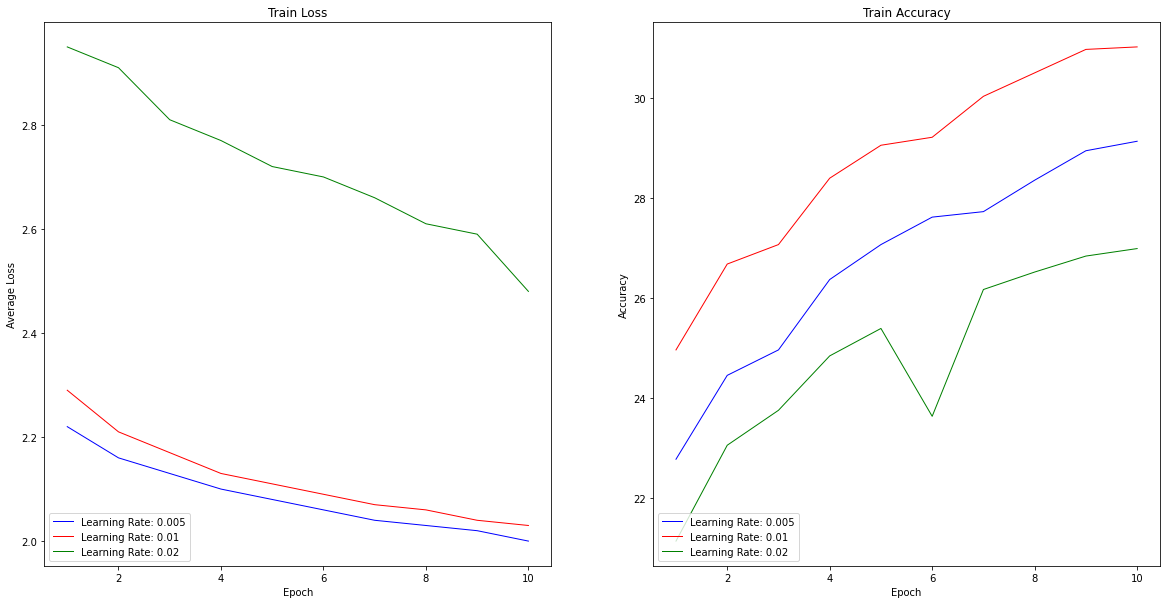

In [55]:
# Neurons: [4096, 10] Batch Size: 128 
loss_005 = [2.22, 2.16, 2.13, 2.10, 2.08, 2.06, 2.04, 2.03, 2.02, 2.00]
acc_005 = [22.77, 24.45, 24.96, 26.37, 27.07, 27.62, 27.73, 28.36, 28.95, 29.14]

loss_01 = [2.29, 2.21, 2.17, 2.13, 2.11, 2.09, 2.07, 2.06, 2.04, 2.03]
acc_01 = [24.96, 26.68, 27.07, 28.40, 29.06, 29.22, 30.04, 30.51, 30.98, 31.03]

loss_02 = [2.95, 2.91, 2.81, 2.77, 2.72, 2.70, 2.66, 2.61, 2.59, 2.48]
acc_02 = [21.13, 23.05, 23.75, 24.84, 25.39, 23.63, 26.17, 26.52, 26.84, 26.99]
plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Single Layer ", " Batch Size: 128 ")

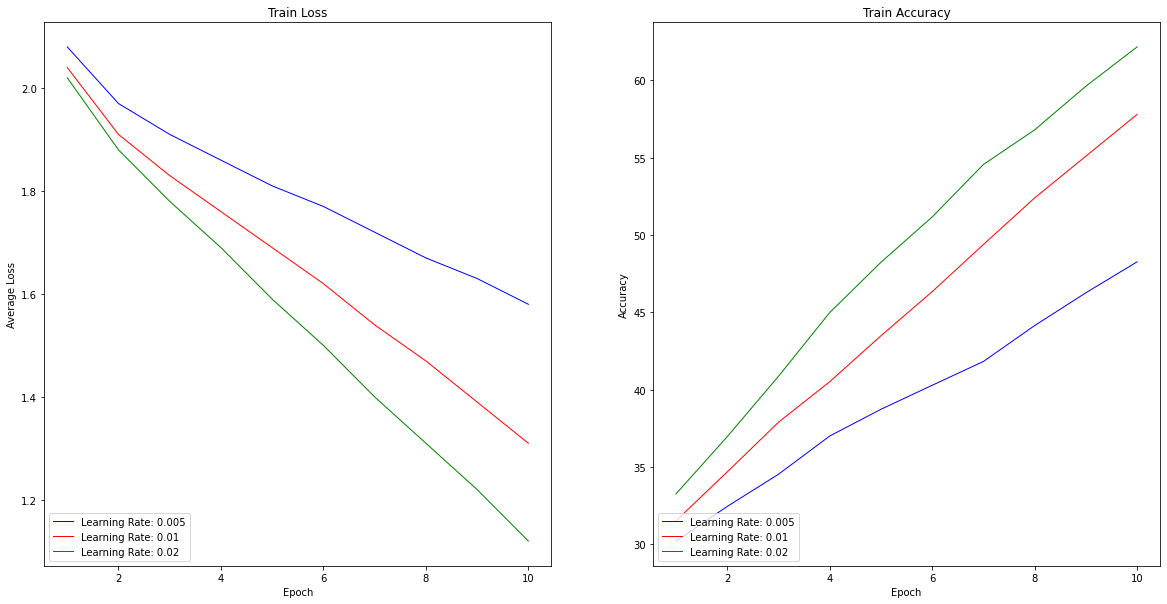

In [56]:
# Neurons: [4096, 1024, 10] Batch Size: 32
loss_005 = [2.08, 1.97, 1.91, 1.86, 1.81, 1.77, 1.72, 1.67, 1.63, 1.58]
acc_005 = [30.21, 32.45, 34.53, 37.00, 38.73, 40.28, 41.82, 44.14, 46.26, 48.26]

loss_01 = [2.04, 1.91, 1.83, 1.76, 1.69, 1.62, 1.54, 1.47, 1.39, 1.31]
acc_01 = [31.52, 34.68, 37.89, 40.51, 43.48, 46.33, 49.38, 52.39, 55.09, 57.79]

loss_02 = [2.02, 1.88, 1.78, 1.69, 1.59, 1.50, 1.40, 1.31, 1.22, 1.12]
acc_02 = [33.26, 36.96, 40.86, 44.98, 48.23, 51.16, 54.55, 56.79, 59.61, 62.15]

plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," One Hidden Layer ", " Batch Size: 32 ")

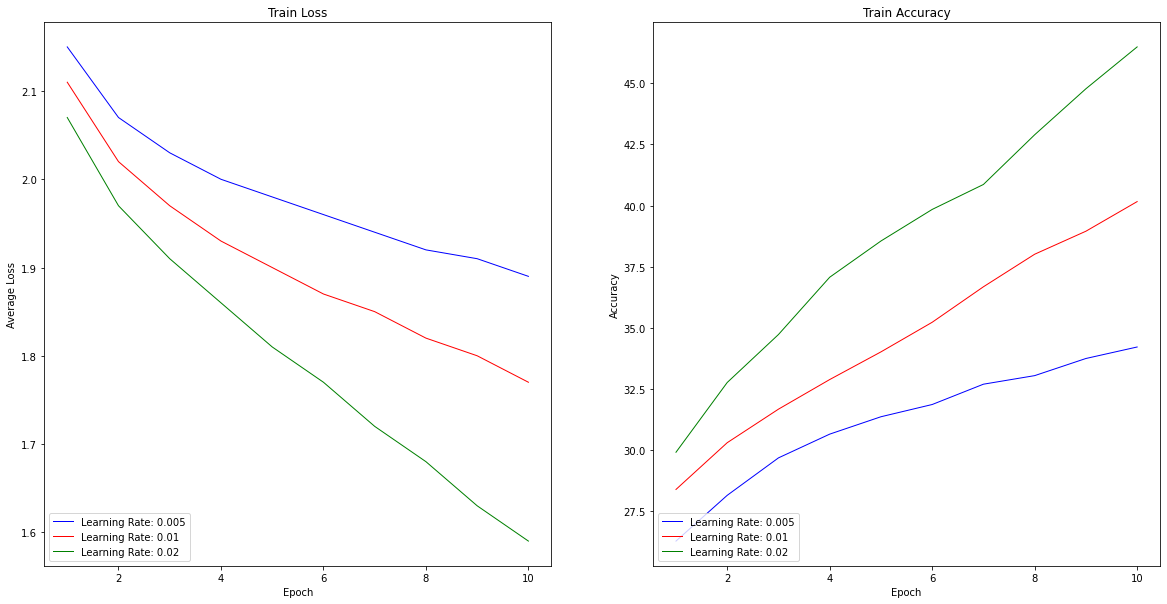

In [57]:
# Neurons: [4096, 1024, 10] Batch Size: 128

loss_005 = [2.15, 2.07, 2.03, 2.00, 1.98, 1.96, 1.94, 1.92, 1.91, 1.89]
acc_005 = [26.29, 28.16, 29.69, 30.66, 31.37, 31.87, 32.70, 33.05, 33.75, 34.22]

loss_01 = [2.11, 2.02, 1.97, 1.93, 1.90, 1.87, 1.85, 1.82, 1.80, 1.77]
acc_01 = [28.40, 30.31, 31.68, 32.89, 34.02, 35.23, 36.68, 38.01, 38.95, 40.16]

loss_02 = [2.07, 1.97, 1.91, 1.86, 1.81, 1.77, 1.72, 1.68, 1.63, 1.59]
acc_02 = [29.92, 32.77, 34.73, 37.07, 38.55, 39.84, 40.86, 42.89, 44.77, 46.48]
plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," One Hidden Layer ", " Batch Size: 128 ")

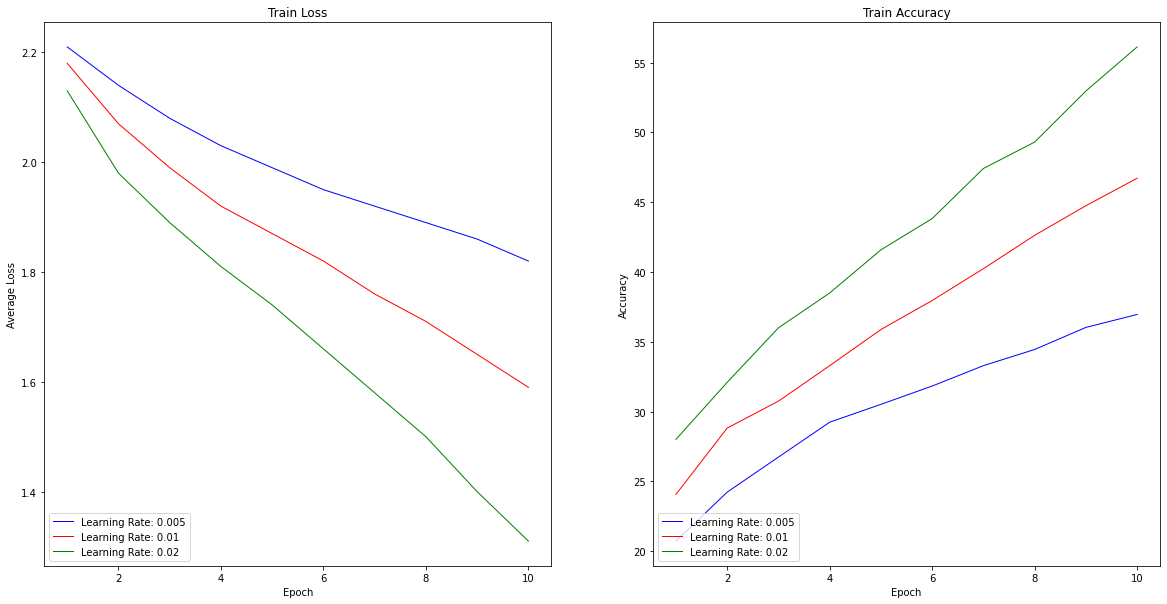

In [58]:
# Neurons: [4096, 1024, 256, 10] Batch Size: 32
loss_005 = [2.21, 2.14, 2.08, 2.03, 1.99, 1.95, 1.92, 1.89, 1.86, 1.82]
acc_005 = [20.72, 24.23, 26.74, 29.24, 30.52, 31.83, 33.29, 34.45, 36.03, 36.96]

loss_01 = [2.18, 2.07, 1.99, 1.92, 1.87, 1.82, 1.76, 1.71, 1.65, 1.59]
acc_01 = [24.07, 28.82, 30.75, 33.29, 35.88, 37.96, 40.24, 42.63, 44.75, 46.72]

loss_02 = [2.13, 1.98, 1.89, 1.81, 1.74, 1.66, 1.58, 1.50, 1.40, 1.31]
acc_02 = [28.01, 32.10, 36.00, 38.50, 41.59, 43.83, 47.42, 49.31, 52.97, 56.13]

plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Two Hidden Layers ", " Batch Size: 32 ")

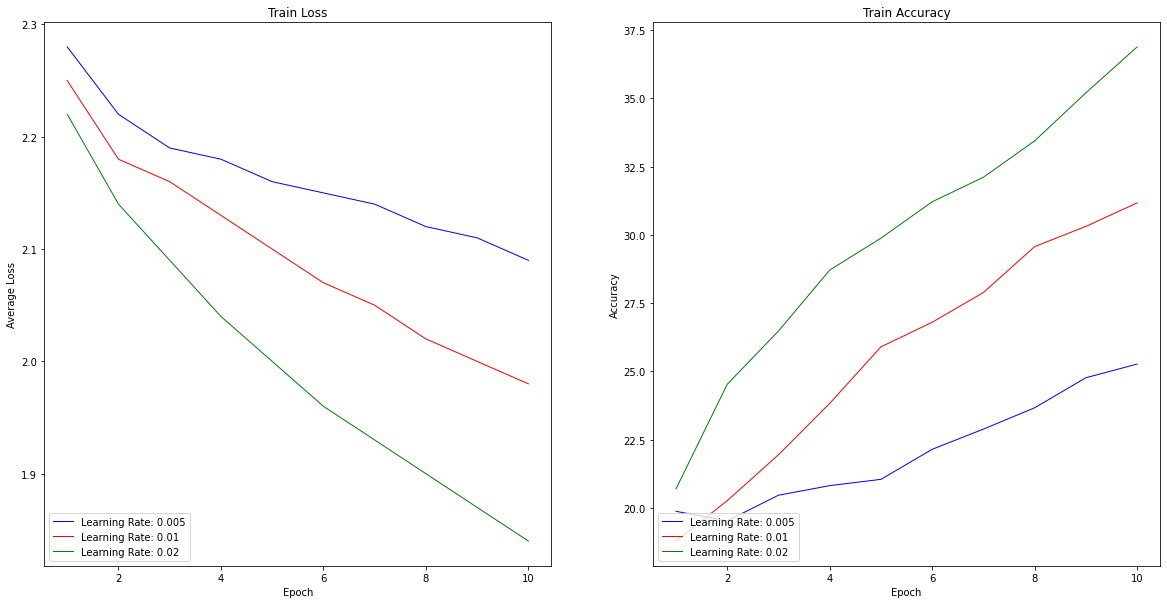

In [59]:
# Neurons: [4096, 1024, 256, 10] Batch Size: 32

loss_005 = [2.28, 2.22, 2.19, 2.18, 2.16, 2.15, 2.14, 2.12, 2.11, 2.09]
acc_005 = [19.88, 19.53, 20.47, 20.82, 21.05, 22.15, 22.89, 23.67, 24.77, 25.27]

loss_01 = [2.25, 2.18, 2.16, 2.13, 2.10, 2.07, 2.05, 2.02, 2.00, 1.98]
acc_01 = [18.79, 20.27, 21.95, 23.83, 25.90, 26.80, 27.89, 29.57, 30.31, 31.17]

loss_02 = [2.22, 2.14, 2.09, 2.04, 2.00, 1.96, 1.93, 1.90, 1.87, 1.84]
acc_02 = [20.70, 24.53, 26.48, 28.71, 29.88, 31.21, 32.11, 33.44, 35.20, 36.88]
plot_graph_lr(loss_005, loss_01, loss_02, acc_005, acc_01, acc_02," Two Hidden Layers ", " Batch Size: 128 ")

## Hidden Layer


In [63]:
from matplotlib import pyplot as plt
def plot_graph_layer(loss_single, loss_one_hidden, loss_two_hidden, acc_single, acc_one_hidden, acc_two_hidden, batch, lr):   
    epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.figure(figsize=(20, 10))
    #plt.suptitle(batchtype+ lr + layer)
    plt.subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.plot(epoch, loss_single, color="blue", label="Single Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_one_hidden, color="red", label="One Hidden Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, loss_two_hidden, color="green", label="Two Hidden Layers", linewidth=1, linestyle="-")


    #plt.plot(epoch, valid_loss, color="red", label="validation", linewidth=1, linestyle="-")
    plt.legend(loc='lower left')
    plt.subplot(1, 2, 2)
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epoch, acc_single, color="blue", label="Single Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_one_hidden, color="red", label="One Hidden Layer", linewidth=1, linestyle="-")
    plt.plot(epoch, acc_two_hidden, color="green", label="Two Hidden Layers", linewidth=1, linestyle="-")

    plt.legend(loc='lower left')
    plt.savefig("graphs_batch"+"/"+batch+lr+".png")
    #plt.close()

If a neural network has only an input and output layer, it is called a single layer neural network. When this is the case, there may be some problems in learning. Because single layer neural network is not a good machine learning method for linearly non-separable data .  But we use the multilayer neural network we will solve this problem.
When using multilayer , a hidden layer and node size important. Because if we use a few hidden layers, we may encounter errors such as overfits, and if we use multiple layers we may encounter errors such as overflow. 

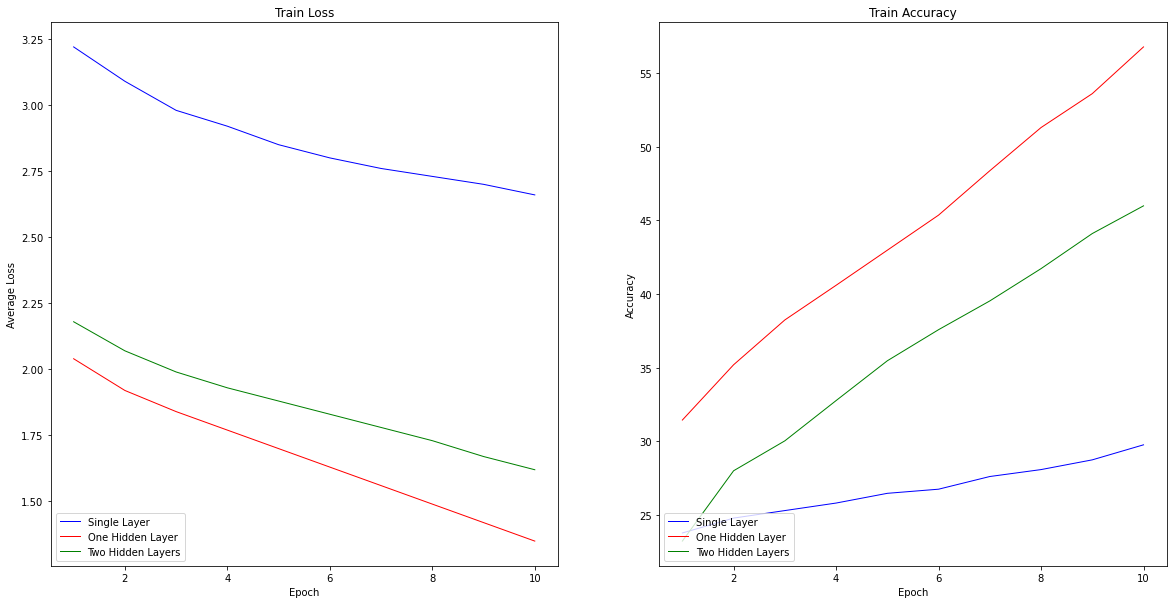

In [64]:
#batch size: 64 lr: 0.02
loss_single = [3.22, 3.09, 2.98, 2.92, 2.85, 2.80, 2.76, 2.73, 2.70, 2.66]
acc_single = [23.79, 24.80, 25.31, 25.82, 26.48, 26.76, 27.62, 28.09, 28.75, 29.77]

loss_one_hidden = [2.04, 1.92, 1.84, 1.77, 1.70, 1.63, 1.56, 1.49, 1.42, 1.35]
acc_one_hidden = [31.45, 35.20, 38.24, 40.59, 42.97, 45.35, 48.36, 51.29, 53.59, 56.76]

loss_two_hidden = [2.18, 2.07, 1.99, 1.93, 1.88, 1.83, 1.78, 1.73, 1.67, 1.62]
acc_two_hidden = [23.24, 28.01, 30.04, 32.77, 35.47, 37.58, 39.53, 41.72, 44.10, 45.98]

plot_graph_layer(loss_single, loss_one_hidden, loss_two_hidden, acc_single, acc_one_hidden, acc_two_hidden, " Batch Size: 128 ", "Lr: 0.02" )

Here we see that the singl layer's learning success is low compared to multilayer results because it contains less weight and therefore cannot produce special reflexes for some stuations.

In multilayer, we see that the increase in the number of layers does not reduce the total loss any further. We observe that in 1-layer, the cost decreases more and the accuracy increases more. We can see that there is significant difference between the accuracy values.

### Forward Propagation

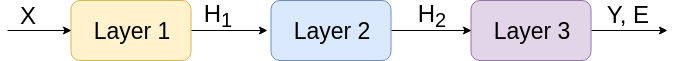

The input data is fed in the forward direction across the network, as the name implies. Each hidden layer accepts data, processes it according to the activation function, and then sends it on to the next layer. The output of each layer becomes the input of the following layer until we reach the network's finish. We may calculate an error E by comparing the network's output with the desired output. The goal is to reduce the error by altering the network's parameters. This is known as reverse propagation (backpropagation)

ADD FORWARD PROPAGATION CODE HERE

### Backpropagation

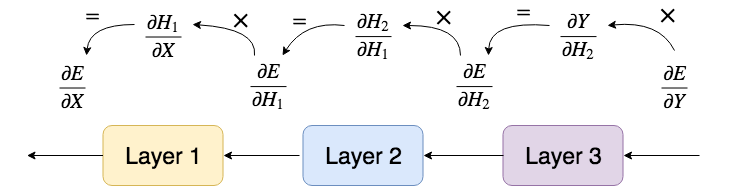

The process of computing the gradient of neural network parameters is known as backpropagation. In a nutshell, the method follows the chain rule from calculus to traverse the network in reverse order, from the output to the input layer.

The partial derivatives of the loss function with respect to the parameters of the last layer, which have no influence over any other network parameters, are calculated first by backpropagation. Because of the chain rule, this is a simple computation. After obtaining these derivatives, we proceed to the previous layer and compute the partial derivatives of the loss function, but this time with regard to the parameters of this layer, which we have partially solved owing to the chain rule. 

The implementation is similar to forward propagation but this time we calculate the derivatives. And used $alpha$ to determine the learning rate.

ADD BACKPROPAGATION CODE HERE

### Activation Functions

In a neural network, an activation function specifies how the weighted sum of the input is turned into an output from a node or nodes in a layer. The activation function chosen has a significant impact on the neural network's capabilities and performance, and different activation functions may be utilized in different portions of the model.

A neural network's activation function is an essential component. A neural network is a simple linear regression model without an activation function. This suggests that the activation function gives the neural network non-linearity.

First, we'll set up the weight matrices and bias vectors. It's crucial to note that we shouldn't set all of the parameters to zero because this will make the gradients equal, the output will be the same on each iteration, and the learning algorithm will not learn anything. As a result, it's critical to set the parameters to random values between 0 and 1.

Activation functions we used:
- "sigmoid" : The function accepts any real value as input and returns a value between 0 and 1. The larger the input (more positive), the closer the output to 1.0, and the smaller the input (more negative), the closer the output to 0.0. We utilize the sigmoid function since it exists between two points (0 to 1). As a result, it is particularly useful in models where the probability must be predicted as an output. Because the likelihood of anything only occurs between 0 and 1, sigmoid is a good option.

### Gradient Descent

In general, the gradient is a numeric calculation allowing us to know how to adjust the parameters of a network in such a way that its output deviation is minimized. The algorithm has several versions depending on the number of samples that we introduce to the network for each iteration, which are batch, stochastic and mini batch. We use mini batch with learning range in the range of (0.005 - 0.2) and batch size of (16-128) in this assignment.

Choosing the appropricate learning rate is an important issue because a small learning rate requires many updates before reaching the minimum point whereas too large of learning rate causes drastic updates which lead to divergent behaviours.

Instead of feeding the network with single data, mini-batch gradient descent introduces N random objects each iteration. This maintains the benefits of the previous version while additionally allowing for faster training due to parallelization of operations. This version of the method will be used, with N set to a value that strikes a suitable balance between unpredictability and training time.

We'll update the network parameters by subtracting the corresponding gradient value from their current values, multiplied by a learning rate that allows us to change the size of our steps, once we've gotten the gradient vector. Because we want to travel in the opposite direction of the gradient, lowering the loss value, the update term is subtracted.

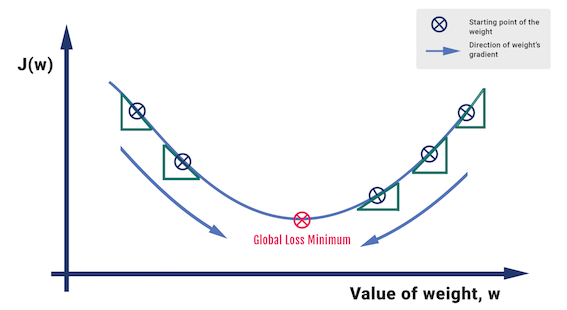

### Loss Function

To reduce algorithmic error, neural networks employ optimization algorithms such as stochastic gradient descent. A Loss Function is used to calculate this error. It's used to determine how well or poorly the model is performing. Before applying gradient descent, we calculate the loss function and then update network parameters w and b to minimize the loss function using gradient descent algorithm.

HANGİ LOSS FUNCTION KULLANILDIRYSA ONA GÖRE AÇIKLAMA YAZ

ADD LOSS FUNCTION IMPLEMENTATIONS HERE

### Softmax

Softmax function takes an N-dimensional vector of real numbers and transforms
it into a vector of real number in range $( 0,1 )$ which add upto $ p _ { i } = \frac { e ^ { a _ { i } } } { \sum _ { k = 1 } ^ { N } e _ { k } ^ { a } }$

This property of softmax function that it outputs a probability distribution makes it suitable for probabilistic interpretation in classification tasks.

Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer. So, we have 10 nodes in the softmax layer.

Softmax takes the concept of logistic regression and applies it to a multi-class world. In a multi-class problem, Softmax assigns decimal probabilities to each class. The sum of those decimal probabilities must equal 1.0. This added constraint allows training to converge faster than it would without.

ADD SOFTMAX CODE IMPLEMENTATIONS HERE

## PART 2: Convolutional Neural Network

<img src="images/cnn1.png">

The higher performance of convolutional neural networks with picture, speech, or audio signal inputs sets them apart from other neural networks. CNNs have three main types of layers, which are: convolutional layer, pooling layer and fully-connected (FC) layer.

A convolutional network's first layer is the convolutional layer. While further convolutional layers or pooling layers can be added after convolutional layers, the fully-connected layer is the last layer. The CNN becomes more complicated with each layer, detecting larger areas of the image. Earlier layers concentrate on basic elements like colors and borders. As the visual data travels through the CNN layers, it begins to distinguish larger elements or features of the item, eventually identifying the target object.

In this part, we builded a convolutional neural network(CNN) with PyTorch to classify images into different animal classes. By the end of this assignment, we become familiar with PyTorch, CNNs, padding, stride, max pooling and we are able to build own CNN model for image classification. 

In [9]:
#import modules 

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from glob import glob

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

from torchvision import transforms
from torchvision.models.vgg import vgg19_bn

In [10]:
def provide_determinism(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class CNNDataset(Dataset):
    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
        "dog": "cane",
        "horse": "cavallo",
        "elephant" : "elefante",
        "butterfly": "farfalla",
        "chicken": "gallina",
        "cat": "gatto",
        "cow": "mucca",
        "sheep": "pecora",
        "spider": "ragno",
        "squirrel": "scoiattolo"
    }

    def __init__(self, data_parent='data/'):
        super().__init__()

        self.data_path = os.path.join(data_parent, 'raw-img')

        self.org_names = list(self.translate.keys())[:10]
        self.eng_names = list(self.translate.keys())[10:]

        
        #translate the class names from Italian to English
        self.data_paths = []
        for i in range(len(self.org_names)):
            img_paths = glob(
                os.path.join(self.data_path, self.org_names[i], '*')
            )
            
            self.data_paths.extend(list(zip(img_paths, [i] * len(img_paths))))
        
        #transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]
            ),
        ])

    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, index):
        img_path, label = self.data_paths[index]
        img = Image.open(img_path).convert('RGB')

        x = self.transform(img)

        return x, label


For training our model, we need a dataset which has images and label attached to it. Our dataset consist of 10 types of images and they stored in corresponding folders.

To prepare a dataset from such a structure, PyTorch provides Transform which makes the task easy for us to prepare the dataset. We simply have to pass the directory of our data to it and it provides the dataset which we can use to train the model.

The torchvision.transforms module provides various functionality to preprocess the images, here first we resize the image for (224*224) shape and then transforms them into tensors.

So our first image in the dataset has a shape (3, 224, 224) which means the image has 3 channels (RGB), height 224, and width 224. 

In [12]:
def cnn_train(train_set, test_set, only_train_fc=False):
    train_loader = DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_set,
        batch_size=128,
        shuffle=False,
        pin_memory=True,
    )

    # VGG is 1000 class network, changing the last layer is a solution
    # but it would change weight distribution so I am not changing it.
    # Model should learn to output only the first 10 class.
    model = vgg19_bn(pretrained=True).to(device)
    
    if only_train_fc:
        for param in model.parameters():
            param.requires_grad = False
        
        # Train only last two linear layers
        for param in model.classifier[3].parameters():
            param.requires_grad = True
        for param in model.classifier[6].parameters():
            param.requires_grad = True
    
    lr = 0.0002 if only_train_fc else 0.0005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    best_acc = -100
    for epoch in range(1, 11):
        model.train()
        
        train_correct = 0
        loss_acc = 0
        epoch_tqdm = tqdm(
            train_loader, total=len(train_loader), leave=True, desc="Train"
        )
        for images, labels in epoch_tqdm:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad(set_to_none=True)

            output = model(images)
            output = output.squeeze(1)
            loss = criterion(output, labels)
            
            loss.backward()

            optimizer.step()

            loss_acc += loss.item()

            output = output.argmax(dim=1)
            train_correct += sum(output==labels)

        optimizer.zero_grad(set_to_none=True)

        model.eval()

        test_correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                output = output.squeeze(1)
                output = output.argmax(dim=1)

                test_correct += sum(output==labels)

        test_acc = (float(test_correct) / len(test_set)) * 100

        if test_acc >= best_acc:
            torch.save(
                {'model': model},
                'vgg_' + ('fc' if only_train_fc else 'full') + '.pth'
            )

            best_acc = test_acc

        print(
            f"Epoch {str(epoch).zfill(3)} | "
            + f"Best Test Acc. = {best_acc:.2f}%"      # Best test. acc.
            + f", Last Test Acc. = {test_acc:.2f}%"     # Last test. acc.
        )
        
        scheduler.step()
    
    return model

We can not pass the whole dataset into our model to train it, because our memory size is fixed and there is a high chance that our training data exceed the memory capacity of CPU or GPU, so we split the dataset into batches and instead of training the model on whole in a single phase.  For example, the batch size can be 16, 32, 64, 128 etc.
Here we take batches of size 128  from the data for training. To randomly split the images into training, PyTorch provides random_split().
The data is divided into batches using the PyTorch DataLoader class. We create two objects train_loader and test_loader for training and validation data respectively by giving parameters training data and batch size into the DataLoader Class.

For this part, VGG -19, a type of CNN model is used, which is 19 weight layers consisting of 16 convolutional layers with 3 fully connected layers and the same 5 pooling layers.
The input is a 224 * 224 RGB image to VGG based convNet. The pre-processing layer takes the RGB image with pixel values in the range 0–255 and subtracts the mean image values computed over the entire ImageNet training collection. After pre-processing, the input images are passed through layers of weight. The training images are processed through a stack of convolutional layers.

Let’s take a brief look at the architecture of our VGG:   

- The first two layers are convolutional layers (also called feature map) with 3x3 filters, and the first two layers use 64 filters that result in 224x224x64. The filters are always 3*3 with a stride of 1.

- Next is the pooling layer with max-pool of 2x2 size and stride 2, which reduces image size from 224x224x64 to 112x112x64. The pooling layer helps to summarise the result obtained by the convolution layer in a lower dimension. 

- This is preceded by 2 more convolution layers with 128 filters, which results in the new dimension of 112x112x128. Again pooling layer is applied, which changes the size to 56x56x128.

- Two more convolution layers are added with 256 filters, each followed by a down-sampling layer, which reduces the size to 28x28x256.

- There are two more stacks, each with 3 convolution layer is separated by a max-pool layer with 7x7x512 volume, which is flattened into a Fully Connected (FC) layer and followed by a softmax layer as output.


In [13]:
def cnn_test(model, test_set):
    test_loader = DataLoader(
        test_set,
        batch_size=128,
        shuffle=False,
        pin_memory=True
    )
    
    model.eval()
    
    conf_mat = torch.zeros(10, 10)
    test_correct = 0
    with torch.no_grad():
        epoch_tqdm = tqdm(
            test_loader, total=len(test_loader), leave=True, desc="Test"
        )
        for images, labels in epoch_tqdm:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            output = output.squeeze(1)
            output = output.argmax(dim=1)
            
            for t, p in zip(labels.view(-1), output.view(-1)):
                conf_mat[t.long(), p.long()] += 1

            test_correct += sum(output==labels)

    test_acc = (float(test_correct) / len(test_set)) * 100
    
    print(f"Test Acc. = {test_acc:.2f}%")
    
    print("Confusion matrix:")
    print(conf_mat)

In [ ]:
if __name__ == "__main__":
    print("Device:", device, "\n")

    provide_determinism(123)

    dataset = CNNDataset()

    test_set_size = len(dataset)//10
    train_set_size = len(dataset)-test_set_size

    train_set, test_set = torch.utils.data.random_split(
        dataset, [train_set_size, test_set_size]
    )
    
    model_fc = cnn_train(train_set, test_set, only_train_fc=True)
    cnn_test(model_fc, test_set)

    model_full = cnn_train(train_set, test_set, only_train_fc=False)
    cnn_test(model_full, test_set)


Device: cpu 



Train:  26%|██▌       | 48/185 [1:56:41<5:12:49, 137.00s/it]

### Confusion Matrix

In [ ]:
import numpy as np

conf_mat =\
[[457.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
 [  0., 262.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
 [  0.,   1., 148.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
 [  0.,   0.,   0., 225.,   0.,   0.,   0.,   0.,   1.,   0.],
 [  0.,   0.,   0.,   0., 323.,   0.,   0.,   0.,   1.,   1.],
 [  0.,   0.,   0.,   0.,   0., 153.,   0.,   0.,   1.,   0.],
 [  1.,   2.,   0.,   0.,   0.,   0., 195.,   2.,   0.,   0.],
 [  1.,   0.,   0.,   0.,   0.,   0.,   0., 186.,   0.,   0.],
 [  0.,   0.,   0.,   3.,   0.,   0.,   0.,   1., 462.,   1.],
 [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 187.]]

conf_mat = np.asarray(conf_mat)

num_class = len(conf_mat)

TP = conf_mat.diagonal()  # True positive
AP = np.sum(conf_mat, axis=0)  # TP + FP
AT = np.sum(conf_mat, axis=1)  # TP + FN

precision = TP / AP
recall = TP / AT
F1 = (2 * precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1:", F1)